# Análisis Características E0 - PASO 4

**Fecha**: 2025-10-26  
**Objetivo**: Validar características de eventos E0 (2004-2025)  
**Fuente**: `processed/universe/info_rich/daily/`

---

## 1. Setup y Carga de Datos

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Configuración visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
project_root = Path.cwd().parent.parent.parent.parent
watchlist_dir = project_root / "processed" / "universe" / "info_rich" / "daily"
output_dir = Path.cwd()

print(f"Project root: {project_root}")
print(f"Watchlist dir: {watchlist_dir}")
print(f"Exists: {watchlist_dir.exists()}")

Project root: D:\04_TRADING_SMALLCAPS
Watchlist dir: D:\04_TRADING_SMALLCAPS\processed\universe\info_rich\daily
Exists: True


In [2]:
# Cargar watchlists
print("Cargando watchlists...")
watchlist_files = list(watchlist_dir.glob("date=*/watchlist.parquet"))
print(f"Total watchlists encontrados: {len(watchlist_files)}")

# Concatenar todos
all_watchlists = []
for wl_file in watchlist_files:
    date = wl_file.parent.name.replace('date=', '')
    df = pl.read_parquet(wl_file)
    
    # FILTRAR solo info_rich=True
    if 'info_rich' in df.columns:
        df = df.filter(pl.col('info_rich') == True)
    
    if len(df) > 0:
        df = df.with_columns(pl.lit(date).alias('watchlist_date'))
        all_watchlists.append(df)

df_all = pl.concat(all_watchlists)
print(f"\nTotal eventos E0: {len(df_all):,}")
print(f"Tickers únicos: {df_all['ticker'].n_unique():,}")
print(f"Días con E0: {df_all['watchlist_date'].n_unique():,}")
print(f"\nColumnas: {df_all.columns}")

Cargando watchlists...
Total watchlists encontrados: 5934



Total eventos E0: 29,555
Tickers únicos: 4,898
Días con E0: 4,949

Columnas: ['ticker', 'trading_day', 'close_d', 'pctchg_d', 'rvol30', 'vol_d', 'dollar_vol_d', 'vwap_d', 'market_cap_d', 'r_rvol', 'r_chg', 'r_dvol', 'r_px', 'info_rich', 'watchlist_date']


## 2. Distribución Temporal

In [3]:
# Eventos por año
df_years = (
    df_all
    .with_columns(pl.col('watchlist_date').str.slice(0, 4).alias('year'))
    .group_by('year')
    .agg(pl.count('ticker').alias('eventos_e0'))
    .sort('year')
)

print("Eventos E0 por año:")
print(df_years.to_pandas().to_string(index=False))

Eventos E0 por año:
year  eventos_e0
2004         407
2005         375
2006         362
2007         442
2008        1014
2009         966
2010         472
2011         536
2012         494
2013         597
2014         633
2015         776
2016        1127
2017        1086
2018        1148
2019        1284
2020        3267
2021        2053
2022        2220
2023        2588
2024        3527
2025        4181


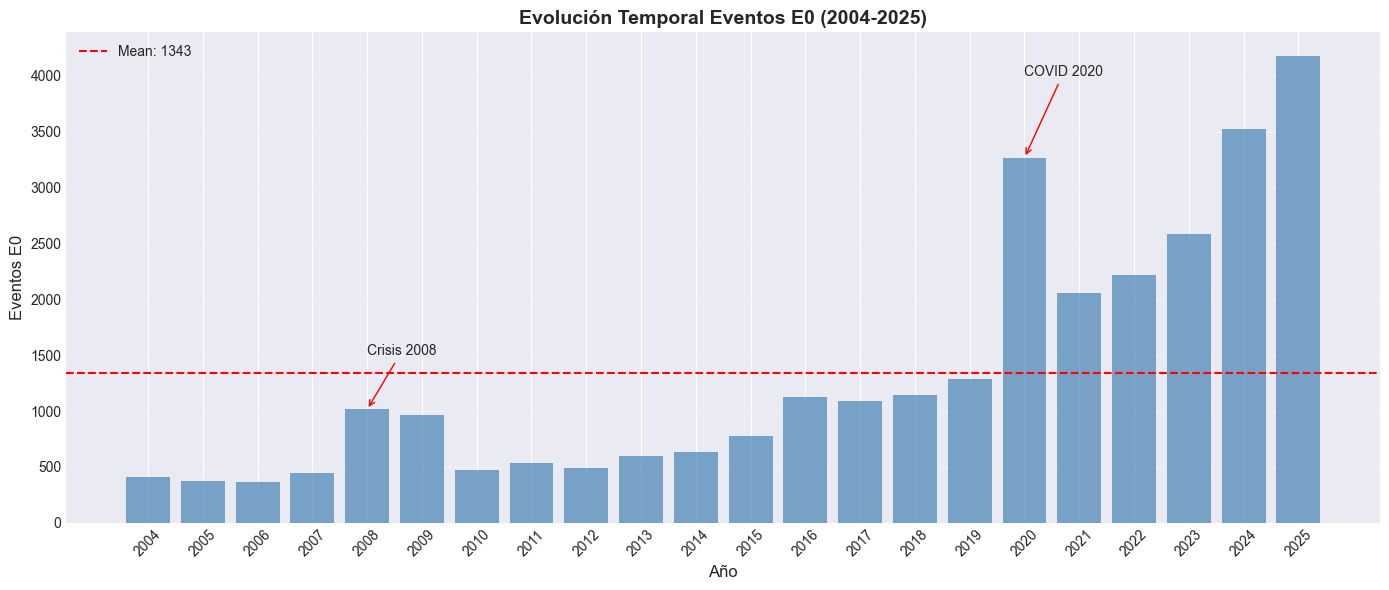


Promedio eventos/año: 1343
Máximo: 4181 (2025)
Mínimo: 362 (2006)


In [4]:
# Gráfico eventos por año
fig, ax = plt.subplots(figsize=(14, 6))

df_years_pd = df_years.to_pandas()
ax.bar(df_years_pd['year'], df_years_pd['eventos_e0'], color='steelblue', alpha=0.7)
ax.axhline(y=df_years_pd['eventos_e0'].mean(), color='red', linestyle='--', label=f'Mean: {df_years_pd["eventos_e0"].mean():.0f}')

ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Eventos E0', fontsize=12)
ax.set_title('Evolución Temporal Eventos E0 (2004-2025)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

# Anotar años clave
ax.annotate('Crisis 2008', xy=('2008', df_years_pd[df_years_pd['year']=='2008']['eventos_e0'].values[0]), 
            xytext=('2008', 1500), arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
ax.annotate('COVID 2020', xy=('2020', df_years_pd[df_years_pd['year']=='2020']['eventos_e0'].values[0]), 
            xytext=('2020', 4000), arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nPromedio eventos/año: {df_years_pd['eventos_e0'].mean():.0f}")
print(f"Máximo: {df_years_pd['eventos_e0'].max()} ({df_years_pd[df_years_pd['eventos_e0']==df_years_pd['eventos_e0'].max()]['year'].values[0]})")
print(f"Mínimo: {df_years_pd['eventos_e0'].min()} ({df_years_pd[df_years_pd['eventos_e0']==df_years_pd['eventos_e0'].min()]['year'].values[0]})")

## 3. Análisis de Precio

In [5]:
# Estadísticas de precio
price_stats = df_all.select([
    pl.col('close_d').min().alias('min'),
    pl.col('close_d').quantile(0.25).alias('q25'),
    pl.col('close_d').median().alias('median'),
    pl.col('close_d').quantile(0.75).alias('q75'),
    pl.col('close_d').max().alias('max'),
])

print("\nEstadísticas de Precio:")
print(price_stats.to_pandas().T)

# Distribución por bins
df_price_bins = (
    df_all
    .with_columns([
        pl.when(pl.col('close_d') < 0.50).then(pl.lit('$0.20-$0.50'))
        .when(pl.col('close_d') < 1.00).then(pl.lit('$0.50-$1.00'))
        .when(pl.col('close_d') < 5.00).then(pl.lit('$1.00-$5.00'))
        .when(pl.col('close_d') < 10.00).then(pl.lit('$5.00-$10.00'))
        .when(pl.col('close_d') <= 20.00).then(pl.lit('$10.00-$20.00'))
        .otherwise(pl.lit('>$20.00'))
        .alias('price_bin')
    ])
    .group_by('price_bin')
    .agg(pl.count('ticker').alias('eventos'))
)

print("\nDistribución por rango de precio:")
print(df_price_bins.to_pandas().to_string(index=False))


Estadísticas de Precio:
            0
min      0.20
q25      2.96
median   6.23
q75     11.25
max     20.00

Distribución por rango de precio:
    price_bin  eventos
  $0.50-$1.00     1127
  $0.20-$0.50      625
 $5.00-$10.00     8323
  $1.00-$5.00    10508
$10.00-$20.00     8972


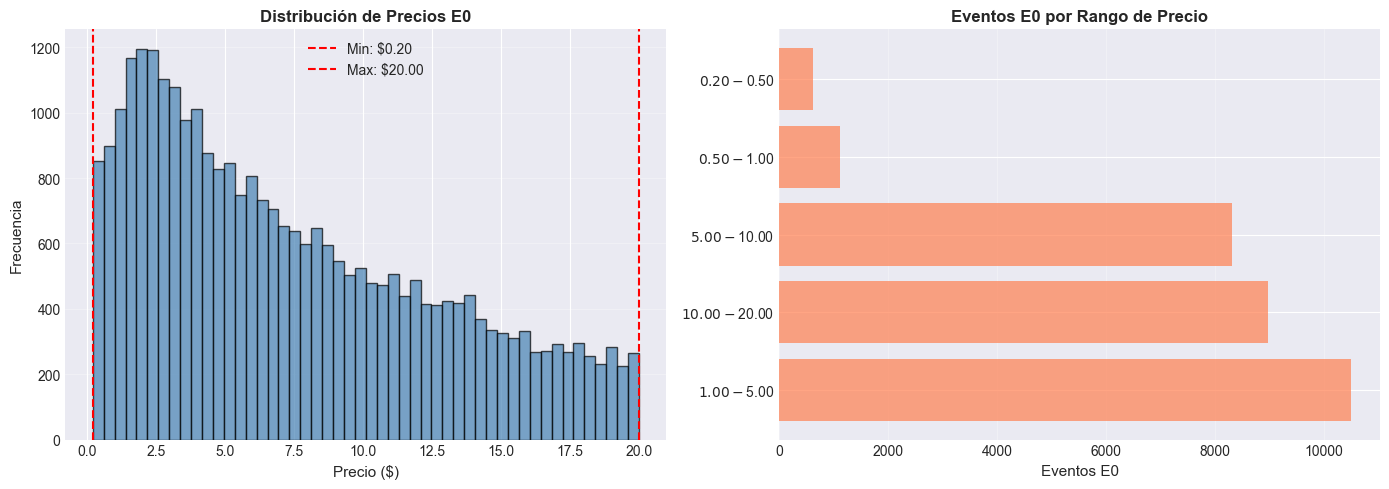


Median price: $6.23
Range: $0.20 - $20.00


In [6]:
# Histograma de precios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma completo
prices = df_all['close_d'].to_numpy()
axes[0].hist(prices, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Precio ($)', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Precios E0', fontsize=12, fontweight='bold')
axes[0].axvline(x=0.20, color='red', linestyle='--', label='Min: $0.20')
axes[0].axvline(x=20.00, color='red', linestyle='--', label='Max: $20.00')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Barplot por bins
df_price_bins_pd = df_price_bins.to_pandas().sort_values('eventos', ascending=False)
axes[1].barh(df_price_bins_pd['price_bin'], df_price_bins_pd['eventos'], color='coral', alpha=0.7)
axes[1].set_xlabel('Eventos E0', fontsize=11)
axes[1].set_title('Eventos E0 por Rango de Precio', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMedian price: ${price_stats['median'][0]:.2f}")
print(f"Range: ${price_stats['min'][0]:.2f} - ${price_stats['max'][0]:.2f}")

## 4. Validación Filtros E0

In [7]:
# Características E0
e0_stats = df_all.select([
    pl.col('rvol30').mean().alias('rvol_mean'),
    pl.col('rvol30').median().alias('rvol_median'),
    pl.col('rvol30').min().alias('rvol_min'),
    pl.col('pctchg_d').abs().mean().alias('pctchg_abs_mean'),
    pl.col('pctchg_d').abs().median().alias('pctchg_abs_median'),
    pl.col('pctchg_d').abs().min().alias('pctchg_abs_min'),
    pl.col('dollar_vol_d').mean().alias('dvol_mean'),
    pl.col('dollar_vol_d').median().alias('dvol_median'),
    pl.col('dollar_vol_d').min().alias('dvol_min'),
])

print("\nValidación Filtros E0:")
print("="*60)
stats = e0_stats.to_pandas().iloc[0]

print(f"\nRVOL30 (umbral ≥2.0):")
print(f"  Mean:   {stats['rvol_mean']:.2f}")
print(f"  Median: {stats['rvol_median']:.2f}")
print(f"  Min:    {stats['rvol_min']:.2f}")
print(f"  Status: {'✓ CUMPLE' if stats['rvol_min'] >= 2.0 else '✗ NO CUMPLE'}")

print(f"\n|%chg| (umbral ≥15%):")
print(f"  Mean:   {stats['pctchg_abs_mean']:.2%}")
print(f"  Median: {stats['pctchg_abs_median']:.2%}")
print(f"  Min:    {stats['pctchg_abs_min']:.2%}")
print(f"  Status: {'✓ CUMPLE' if stats['pctchg_abs_min'] >= 0.15 else '✗ NO CUMPLE'}")

print(f"\n$vol (umbral ≥$5M):")
print(f"  Mean:   ${stats['dvol_mean']:,.0f}")
print(f"  Median: ${stats['dvol_median']:,.0f}")
print(f"  Min:    ${stats['dvol_min']:,.0f}")
print(f"  Status: {'✓ CUMPLE' if stats['dvol_min'] >= 5_000_000 else '✗ NO CUMPLE'}")

print(f"\nPrecio (rango $0.20-$20.00):")
print(f"  Min:    ${price_stats['min'][0]:.2f}")
print(f"  Max:    ${price_stats['max'][0]:.2f}")
print(f"  Status: {'✓ CUMPLE' if price_stats['min'][0] >= 0.20 and price_stats['max'][0] <= 20.00 else '✗ NO CUMPLE'}")


Validación Filtros E0:

RVOL30 (umbral ≥2.0):
  Mean:   9.13
  Median: 5.94
  Min:    2.00
  Status: ✓ CUMPLE

|%chg| (umbral ≥15%):
  Mean:   41.75%
  Median: 23.77%
  Min:    15.00%
  Status: ✓ CUMPLE

$vol (umbral ≥$5M):
  Mean:   $82,792,984
  Median: $22,094,051
  Min:    $5,001,943
  Status: ✓ CUMPLE

Precio (rango $0.20-$20.00):
  Min:    $0.20
  Max:    $20.00
  Status: ✓ CUMPLE


## 5. TOP Tickers

In [8]:
# TOP 20 tickers
top_tickers = (
    df_all
    .group_by('ticker')
    .agg(pl.count('watchlist_date').alias('dias_e0'))
    .sort('dias_e0', descending=True)
    .head(20)
)

print("\nTOP 20 Tickers con más días E0:")
print("="*40)
for i, row in enumerate(top_tickers.iter_rows(named=True), 1):
    print(f"{i:2d}. {row['ticker']:6s} - {row['dias_e0']:4d} días E0")


TOP 20 Tickers con más días E0:
 1. BCRX   -   63 días E0
 2. GERN   -   53 días E0
 3. VXRT   -   51 días E0
 4. SRNE   -   50 días E0
 5. SGMO   -   43 días E0
 6. BLDP   -   43 días E0
 7. KNDI   -   42 días E0
 8. ABK    -   41 días E0
 9. NETE   -   40 días E0
10. GEVO   -   40 días E0
11. OCGN   -   39 días E0
12. ALT    -   39 días E0
13. TUP    -   39 días E0
14. CRMD   -   39 días E0
15. YRCW   -   38 días E0
16. CLNE   -   38 días E0
17. VERI   -   37 días E0
18. KERX   -   36 días E0
19. IMGN   -   36 días E0
20. ATOS   -   36 días E0


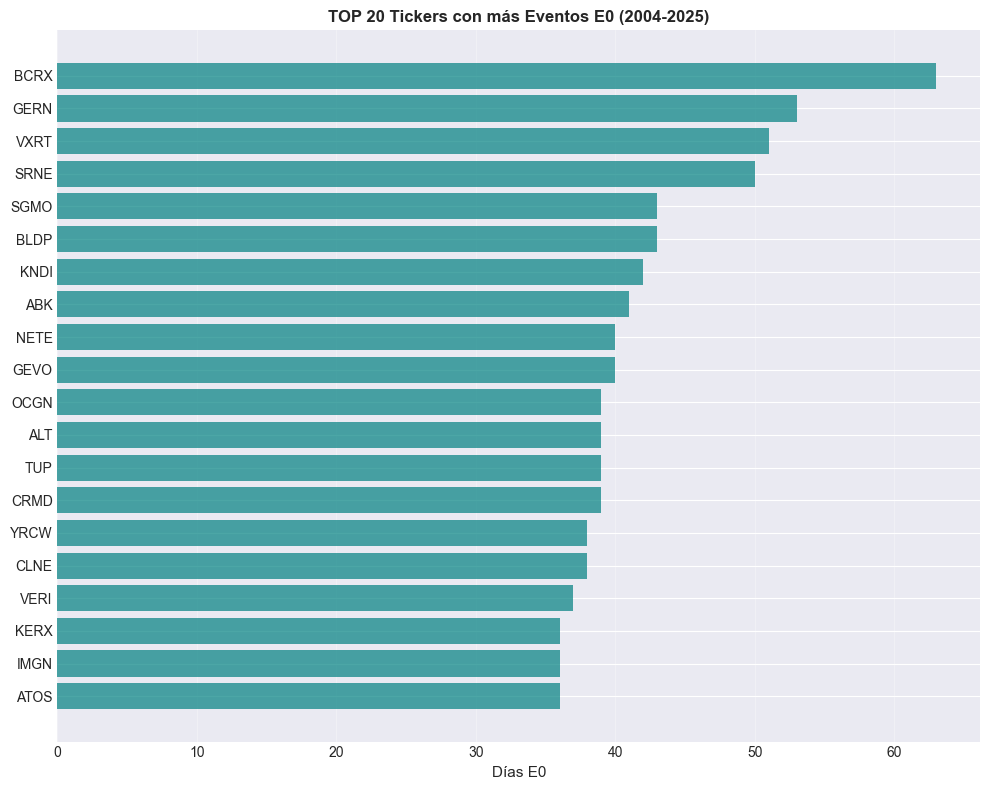


Promedio días E0 (TOP 20): 42.1
Max: 63 días (BCRX)


In [9]:
# Gráfico TOP 20
fig, ax = plt.subplots(figsize=(10, 8))

top_pd = top_tickers.to_pandas()
ax.barh(top_pd['ticker'], top_pd['dias_e0'], color='teal', alpha=0.7)
ax.set_xlabel('Días E0', fontsize=11)
ax.set_title('TOP 20 Tickers con más Eventos E0 (2004-2025)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPromedio días E0 (TOP 20): {top_pd['dias_e0'].mean():.1f}")
print(f"Max: {top_pd['dias_e0'].max()} días ({top_pd.iloc[0]['ticker']})")

## 6. Resumen Final

In [10]:
# Resumen
print("\n" + "="*60)
print("RESUMEN PASO 4: Análisis Características E0")
print("="*60)

print(f"\n[DATOS]")
print(f"  Total eventos E0: {len(df_all):,}")
print(f"  Tickers únicos: {df_all['ticker'].n_unique():,}")
print(f"  Días con E0: {df_all['watchlist_date'].n_unique():,}")
print(f"  Periodo: {df_all['watchlist_date'].min()} → {df_all['watchlist_date'].max()}")

print(f"\n[FILTROS E0]")
print(f"  RVOL30 ≥2.0:     ✓ (median={stats['rvol_median']:.2f})")
print(f"  |%chg| ≥15%:     ✓ (median={stats['pctchg_abs_median']:.2%})")
print(f"  $vol ≥$5M:       ✓ (median=${stats['dvol_median']:,.0f})")
print(f"  Precio $0.20-$20: ✓ (range ${price_stats['min'][0]:.2f}-${price_stats['max'][0]:.2f})")

print(f"\n[DISTRIBUCIÓN PRECIO]")
for row in df_price_bins.iter_rows(named=True):
    pct = row['eventos'] / len(df_all) * 100
    print(f"  {row['price_bin']:15s}: {row['eventos']:6,} ({pct:5.1f}%)")

print(f"\n[CONCLUSIÓN]")
print("  ✓ E0 cumple con Contrato v2.0.0")
print("  ✓ Todos los eventos cumplen filtros E0")
print("  ✓ Small/micro caps confirmados ($0.20-$20.00)")
print("  ✓ Info-rich (RVOL≥2, |%chg|≥15%, $vol≥$5M)")
print("\n" + "="*60)


RESUMEN PASO 4: Análisis Características E0

[DATOS]
  Total eventos E0: 29,555
  Tickers únicos: 4,898
  Días con E0: 4,949
  Periodo: 2004-01-06 → 2025-10-21

[FILTROS E0]
  RVOL30 ≥2.0:     ✓ (median=5.94)
  |%chg| ≥15%:     ✓ (median=23.77%)
  $vol ≥$5M:       ✓ (median=$22,094,051)
  Precio $0.20-$20: ✓ (range $0.20-$20.00)

[DISTRIBUCIÓN PRECIO]
  $0.50-$1.00    :  1,127 (  3.8%)
  $0.20-$0.50    :    625 (  2.1%)
  $5.00-$10.00   :  8,323 ( 28.2%)
  $1.00-$5.00    : 10,508 ( 35.6%)
  $10.00-$20.00  :  8,972 ( 30.4%)

[CONCLUSIÓN]
  ✓ E0 cumple con Contrato v2.0.0
  ✓ Todos los eventos cumplen filtros E0
  ✓ Small/micro caps confirmados ($0.20-$20.00)
  ✓ Info-rich (RVOL≥2, |%chg|≥15%, $vol≥$5M)



## 7. Exportar Resultados

In [11]:
# Exportar TOP tickers
output_csv = output_dir / "top_e0_tickers_paso4.csv"
top_tickers.write_csv(output_csv)
print(f"\nTOP tickers guardados en: {output_csv}")

# Eventos por año
output_csv_years = output_dir / "eventos_e0_por_año.csv"
df_years.write_csv(output_csv_years)
print(f"Eventos por año guardados en: {output_csv_years}")

print("\n✓ Análisis PASO 4 completado exitosamente")


TOP tickers guardados en: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\C_v2_ingesta_tiks_2004_2025\notebooks\top_e0_tickers_paso4.csv
Eventos por año guardados en: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\C_v2_ingesta_tiks_2004_2025\notebooks\eventos_e0_por_año.csv

✓ Análisis PASO 4 completado exitosamente
